# **Test notebook for the WongSolver**

## Default simulation parameters for the Glasma and the Wong solvers

In [1]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 10      
N = 512    
tau_sim = 1.0     
DTS = 8     

# Glasma
su_group = 'su3'
Qs = 2        
ns = 50    
factor = 0.8        
g2mu = Qs / factor     
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))          		
mu = g2mu / g**2          	
ir = 0.1 * g**2 * mu         
uv = 10.0           

# Wong
mass = 10**8      
tau_form = 0     
pT = 0    
ntp = 10**5  
nevents = 1    
representation = 'fundamental'      
boundary = 'periodic'       

## Set environment variables

In [2]:
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
os.environ["GAUGE_GROUP"] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

Using CUDA
Using SU(3)
Using double precision
Using double precision


# Casimir scaling & conservation of Casimirs

In [3]:
# Wong modules
from curraun import wong
wong.BOUNDARY = boundary
wong.CASIMIRS = True
from curraun.wong import init_mom_toy, init_pos, init_charge

# Dictionary with paraameters
p = {'representation' : representation}

## Simulation routine for evolving the Glasma & solving Wong's equations
Computes the transverse momentum broadening.

In [4]:
import pickle
from tqdm import tqdm

# Simulation routine
def simulate(p, ev): 
    representation = p["representation"]

    output = {}
    output["parameters"] = p.copy()

    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    formt = int(tau_form / a * DTS)
    maxt = int(tau_sim / a * DTS)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # Initialize the Wong solver
    wong_solver = wong.WongSolver(s, ntp)
    x0s, p0s, q0s = np.zeros((ntp, 3)), np.zeros((ntp, 5)), np.zeros((ntp, su.ALGEBRA_ELEMENTS))
    masses = mass / E0 * np.ones(ntp)

    for i in range(ntp):
        x0, p0, q0 = init_pos(s.n), init_mom_toy('pT', pT / E0), init_charge(representation)
        x0s[i, :], p0s[i, :], q0s[i, :] = x0, p0, q0

    wong_solver.initialize(x0s, p0s, q0s, masses)

    mom_broad_T = np.zeros(maxt-formt)
    casimirs = np.zeros((maxt-formt, ntp, su.CASIMIRS))

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):
            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            # Solve Wong's equations
            if t>=formt:  
                mom_broad = wong_solver.p_sq_mean 
                mom_broad_T[t-formt] = (mom_broad[0] + mom_broad[1]) * E0**2

                wong_solver.evolve()
                wong_solver.compute_mom_broad()

                wong_solver.compute_casimirs(representation)
                casimirs[t-formt] = wong_solver.c.copy()

            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)

    output["mom_broad_T"] = mom_broad_T
    output["casimirs"] = casimirs

    return output

## Running the Wong solver over multiple Glasma events

In [5]:
print(su_group[0:2].upper() + '(' + su_group[2] + ')' + ' gauge group')
representations = ['adjoint', 'fundamental']

mom_broad_T = {}
casimirs = {}

for representation in representations:
    p["representation"] =  representation
    print(representation.capitalize() + ' representation')

    mom_broads_T = []
    for ev in range(nevents):
        output = simulate(p, ev)
        mom_broads_T.append(output["mom_broad_T"])
        if ev==0:
            casimirs[representation] = output["casimirs"]

    mom_broad_T[representation] = np.mean(mom_broads_T, axis=0)

formt, maxt = int(tau_form / L * N * DTS), int(tau_sim / L * N * DTS)
tau = np.linspace(tau_form, tau_sim, maxt-formt)

output = {}
output["mom_broad_T"], output["tau"] = mom_broad_T, tau
output["representations"] = representations
output["casimirs"] = casimirs

filename = 'casimir_scaling_' + su_group + '.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(output, handle)

SU(3) gauge group
Adjoint representation


Event 5: 100%|██████████| 409/409 [02:15<00:00,  3.01it/s]


Fundamental representation


Event 5: 100%|██████████| 409/409 [02:15<00:00,  3.01it/s]


## Read data from files

In [7]:
import pickle

su_groups = ['su2', 'su3']
results = {}
for su_group in su_groups:
    results[su_group] = pickle.load(open('casimir_scaling_' + su_group + '.pickle', 'rb'))
representations = results['su2']['representations']

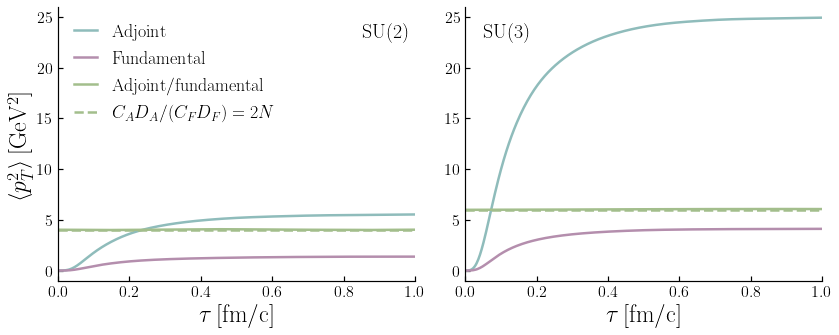

In [8]:
import matplotlib.pyplot as plt
import numpy as np 

plt.style.use('nord_theme_light.mpltstyle')
plt.rcParams["figure.figsize"] = (12,5)

fig, ax = plt.subplots(1, 2)

ax[0].set_ylabel(r'$\langle p_T^2\rangle\,\mathrm{[GeV^2]}$')

Ns = [2, 3]

for i, su_group in enumerate(su_groups):
    Nc = Ns[i]
    Df, Da = Nc, Nc**2-1
    Cf, Ca = (Nc**2-1)/(2*Nc), Nc

    # sigmapt_adj, sigmapt_fund = results[su_group]['sigmapt']['adjoint'], results[su_group]['sigmapt']['fundamental']
    sigmapt_adj, sigmapt_fund = results[su_group]['mom_broad_T']['adjoint'], results[su_group]['mom_broad_T']['fundamental']
    ratio = np.divide(sigmapt_adj, sigmapt_fund)
    tau = results[su_group]['tau']

    ax[i].plot(tau, sigmapt_adj,  label=r'$\mathrm{Adjoint}$', linewidth=2.5)
    ax[i].plot(tau, sigmapt_fund, label=r'$\mathrm{Fundamental}$', linewidth=2.5)
    ax[i].plot(tau, ratio, label=r'$\mathrm{Adjoint/fundamental}$', linewidth=2.5)
    ax[i].plot(tau, Ca*Da/(Cf*Df)*np.ones(tau.shape[0]), label=r'$C_AD_A/(C_FD_F)=2N$', linestyle='--', color='#A3BE8C', linewidth=2.5)

    ax[i].set_xlabel(r'$\tau\,\mathrm{[fm/c]}$')
    ax[i].set_ylim(-1, 26)
    ax[i].set_xlim(0, 1.0)

ax[0].legend(loc='upper left')

ax[0].text(0.85, 23, r'$\mathrm{SU(2)}$', size=20)
ax[1].text(0.05, 23, r'$\mathrm{SU(3)}$', size=20)

plt.tight_layout()
plt.savefig('casimir_scaling_su2+su3.png', dpi=300, transparent=False, facecolor='white')

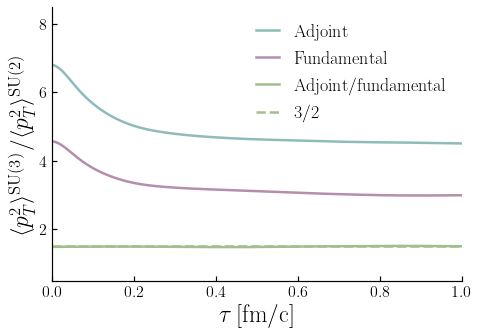

In [9]:
import matplotlib.pyplot as plt

plt.style.use('nord_theme_light.mpltstyle')
plt.rcParams["figure.figsize"] = (7,5)

fig = plt.figure()

plt.ylabel(r'$\langle p_T^2\rangle^\mathrm{SU(3)}/\langle p_T^2\rangle^\mathrm{SU(2)}$')
plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$')

Ns, labels = [2, 3], [r'$\mathrm{Adjoint}$', r'$\mathrm{Fundamental}$']

ratio = {}
for i, representation in enumerate(representations):
    # sigmapt_su2, sigmapt_su3 = results['su2']['sigmapt'][representation], results['su3']['sigmapt'][representation]
    sigmapt_su2, sigmapt_su3 = results['su2']['mom_broad_T'][representation], results['su3']['mom_broad_T'][representation]
    ratio[representation] = np.divide(sigmapt_su3, sigmapt_su2)
    tau = results['su2']['tau']

    plt.plot(tau, ratio[representation], label=labels[i], linewidth = 2.5)

ratio = np.divide(ratio['adjoint'], ratio['fundamental'])
plt.plot(tau, ratio, label=r'$\mathrm{Adjoint/fundamental}$', linewidth = 2.5)
plt.plot(tau, np.ones(tau.shape[0])*Ns[1]/Ns[0], label=r'$3/2$', linestyle='--', color='#A3BE8C', linewidth = 2.5)
plt.ylim(0.5, 8.5)
plt.xlim(0, 1)

plt.legend(loc='upper right')

plt.tight_layout()
plt.savefig('mom_broad_ratio_su3_su2.png', dpi=300, transparent=False, facecolor='white')

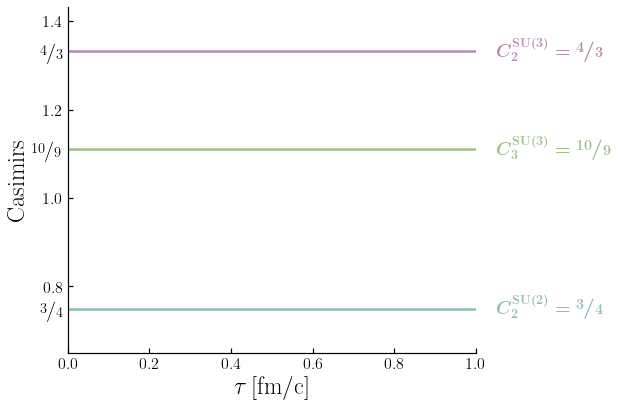

In [10]:
import matplotlib.pyplot as plt
plt.style.use('nord_theme_light.mpltstyle')
plt.rcParams["figure.figsize"] = (9,6)
import matplotlib
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{xfrac}']

fig, ax = plt.subplots()

plt.ylabel(r'$\mathrm{Casimirs}$')
plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$')

labels = [r'$\mathrm{Adjoint}$', r'$\mathrm{Fundamental}$']
colors = ['#8FBCBB', '#B48EAD', '#A3BE8C']
linestyles = ['--', '-']

tau = results['su2']['tau']
casimirs_su2 = results['su2']['casimirs']
plt.plot(tau, casimirs_su2['fundamental'][:, 0], color=colors[0], linewidth = 2.5)
plt.text(1.05, 0.74, r'\boldmath$C_2^\mathrm{SU(2)}={\huge\sfrac{3}{\,4}}$', fontsize=18, color=colors[0])

casimirs_su3 = results['su3']['casimirs']
plt.plot(tau, casimirs_su3['fundamental'][:, 0, 0], color=colors[1], linewidth = 2.5)
plt.text(1.05, 1.32, r'\boldmath$C_2^\mathrm{SU(3)}={\huge\sfrac{4}{\,3}}$', fontsize=18, color=colors[1])

plt.plot(tau, casimirs_su3['fundamental'][:, 0, 1], color=colors[2], linewidth = 2.5)
plt.text(1.05, 1.1, r'\boldmath$C_3^\mathrm{SU(3)}={\huge\sfrac{10}{\,9}}$', fontsize=18, color=colors[2])

ax.set_ylim(3/4-0.1, 4/3+0.1)
ticks = [3/4, 0.8, 1.0, 10/9, 1.2, 4/3, 1.4]
ax.set_yticks(ticks)
labels = [r'$\huge\sfrac{3}{\,4}$', r'$0.8$', r'$1.0$', r'$\huge\sfrac{10}{\,9}$', r'$1.2$', r'$\huge\sfrac{4}{\,3}$', r'$1.4$']
ax.set_yticklabels(labels)

ax.set_xlim(0,1)

plt.tight_layout()
plt.savefig('casimirs_su2+su3.png', dpi=300, transparent=False, facecolor='white')

# Comparison with `qhat.py` for $p_x\rightarrow\infty$

In [8]:
# Wong modules
from curraun import wong
wong.CASIMIRS = False
wong.BOUNDARY = boundary
# wong.LIMITING_CASE = True
from curraun.wong import init_mom_toy, init_pos, init_charge

# Qhat module
import curraun.qhat as qhat

N = 1024     
tau_sim = 5.0     
DTS = 2    

mass = 1
px = 10**8 

## Simulation routine for evolving the Glasma & solving Wong's equations
Computes $\langle p_x^2\rangle$, $\langle p_y^2\rangle$ and $\langle p_z^2\rangle$.

In [9]:
import pickle
from tqdm import tqdm

# Simulation routine
def simulate(ev): 
    output = {}

    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    formt = int(tau_form / a * DTS)
    maxt = int(tau_sim / a * DTS)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # Initialize the Wong solver
    wong_solver = wong.WongSolver(s, ntp)
    x0s, p0s, q0s = np.zeros((ntp, 3)), np.zeros((ntp, 5)), np.zeros((ntp, su.ALGEBRA_ELEMENTS))
    masses = mass / E0 * np.ones(ntp)

    for i in range(ntp):
        x0, p0, q0 = init_pos(s.n), init_mom_toy('px', px / E0), init_charge(representation)
        x0s[i, :], p0s[i, :], q0s[i, :] = x0, p0, q0

    wong_solver.initialize(x0s, p0s, q0s, masses)

    # Momentum broadening from the Wong solver
    mom_broad_wong = np.zeros((maxt-formt, 4))

    # Initialize the qhat.py module
    qhat_tforce = qhat.TransportedForce(s)
    mom_broad_qhat, tau_qhat =  [], []

    if use_cuda:
        qhat_tforce.copy_to_device()

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):
            # Solve Wong's equations
            if t>=formt:  
                # Compute momentum broadening from Wong solver
                mom_broad_wong[t-formt] = wong_solver.p_sq_mean * E0**2
                wong_solver.evolve()
                wong_solver.compute_mom_broad()

                # Compute momentum broadening from the qhat.py module
                if t % DTS == 0:
                    if use_cuda:
                        qhat_tforce.copy_mean_to_host()

                    mom_broad_qhat.append(qhat_tforce.p_perp_mean * E0 ** 2)
                    tau_qhat.append(t*a/DTS)
                    
                    if use_cuda:
                        qhat_tforce.copy_mean_to_device()
                qhat_tforce.compute()

            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)

    output["mom_broad_wong"] = mom_broad_wong
    output["mom_broad_qhat"], output["tau_qhat"] = mom_broad_qhat, tau_qhat

    if use_cuda:
        cuda.current_context().deallocations.clear()

    return output

## Running the Wong solver over multiple Glasma events

In [10]:
mom_broads_wong, mom_broads_qhat = [], []

for ev in range(nevents):
    output = simulate(ev)
    mom_broads_wong.append(output["mom_broad_wong"])
    mom_broads_qhat.append(np.array(output["mom_broad_qhat"]))

mom_broad_wong, mom_broad_qhat = np.mean(mom_broads_wong, axis=0), np.mean(mom_broads_qhat, axis=0)

formt, maxt = int(tau_form / L * N * DTS), int(tau_sim / L * N * DTS)
tau_wong = np.linspace(tau_form, tau_sim, maxt-formt)
tau_qhat = np.array(output["tau_qhat"])

output = {}
output["mom_broad_wong"], output["tau_wong"] = mom_broad_wong, tau_wong
output["mom_broad_qhat"], output["tau_qhat"] = mom_broad_qhat, tau_qhat
output["Qs"], output["hbarc"] = Qs, hbarc

filename = 'wong_vs_qhat.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(output, handle)

Event 1: 100%|██████████| 1024/1024 [33:10<00:00,  1.94s/it]


## Read data from files

In [8]:
import pickle

output = pickle.load(open('wong_vs_qhat.pickle', 'rb'))
mom_broad_wong, tau_wong = output["mom_broad_wong"], output["tau_wong"]
mom_broad_qhat, tau_qhat = output["mom_broad_qhat"], output["tau_qhat"]
Qs, hbarc = output["Qs"], output["hbarc"]

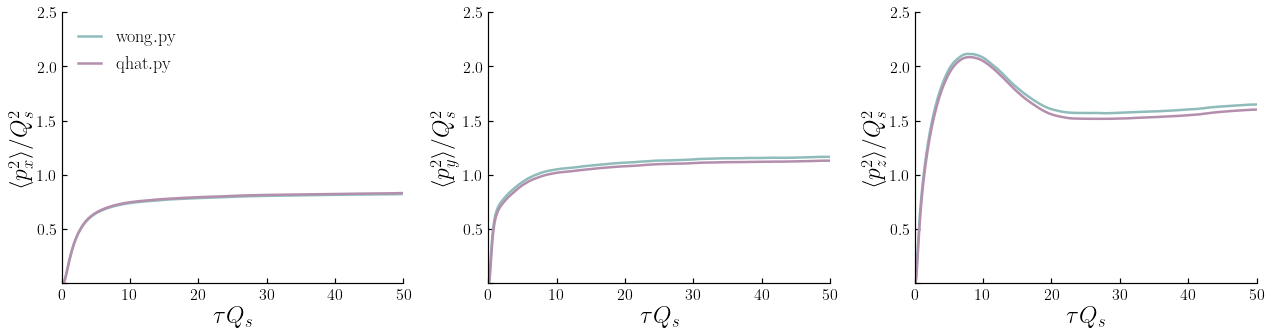

In [9]:
import matplotlib.pyplot as plt
import numpy as np 

plt.style.use('nord_theme_light.mpltstyle')
plt.rcParams["figure.figsize"] = (18,5)
plt.rcParams["figure.subplot.wspace"] = 0.2

fig, ax = plt.subplots(1, 3)

# labels = [r'$\langle p_x^2\rangle\,\mathrm{[GeV^2]}$', r'$\langle p_y^2\rangle\,\mathrm{[GeV^2]}$', r'$\langle p_z^2\rangle\,\mathrm{[GeV^2]}$']
# for i in range(3):
#     ax[i].plot(tau_wong, mom_broad_wong[:, i],  label=r'$\mathrm{wong.py}$')
#     ax[i].plot(tau_qhat, mom_broad_qhat[:, i], label=r'$\mathrm{qhat.py}$')
#     ax[i].set_xlabel(r'$\tau\,\mathrm{[fm/c]}$')
#     ax[i].set_ylabel(labels[i])

# dimensionless quantities
labels = [r'$\langle p_x^2\rangle/Q_s^2$', r'$\langle p_y^2\rangle/Q_s^2$', r'$\langle p_z^2\rangle/Q_s^2$']
for i in range(3):
    ax[i].plot(tau_wong*Qs/hbarc, mom_broad_wong[:, i]/Qs**2,  label=r'$\mathrm{wong.py}$', linewidth=2.5)
    ax[i].plot(tau_qhat*Qs/hbarc, mom_broad_qhat[:, i]/Qs**2, label=r'$\mathrm{qhat.py}$', linewidth=2.5)
    ax[i].set_xlabel(r'$\tau Q_s$')
    ax[i].set_ylabel(labels[i])
    ax[i].set_xlim(0, 50)
    ax[i].set_ylim(0, 2.5)
    ax[i].yaxis.get_major_ticks()[0].label1.set_visible(False)

ax[0].legend(loc='upper left')

plt.tight_layout()
plt.savefig('wong_vs_qhat.png', dpi=300, transparent=False, facecolor='white')

# Comparison with `kappa.py` for $m\rightarrow\infty$

In [3]:
# Wong modules
from curraun import wong
wong.CASIMIRS = False
wong.BOUNDARY = boundary
# wong.LIMITING_CASE = True
from curraun.wong import init_mom_toy, init_pos, init_charge

# Kappa module
import curraun.kappa as kappa

N = 1024     
tau_sim = 5.0     
DTS = 2    

## Simulation routine for evolving the Glasma & solving Wong's equations
Computes $\langle p_x^2\rangle$, $\langle p_y^2\rangle$ and $\langle p_z^2\rangle$.

In [4]:
import pickle
from tqdm import tqdm

# Simulation routine
def simulate(ev): 
    output = {}

    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    formt = int(tau_form / a * DTS)
    maxt = int(tau_sim / a * DTS)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # Initialize the Wong solver
    wong_solver = wong.WongSolver(s, ntp)
    x0s, p0s, q0s = np.zeros((ntp, 3)), np.zeros((ntp, 5)), np.zeros((ntp, su.ALGEBRA_ELEMENTS))
    masses = mass / E0 * np.ones(ntp)

    for i in range(ntp):
        x0, p0, q0 = init_pos(s.n), init_mom_toy('pT', pT / E0), init_charge(representation)
        x0s[i, :], p0s[i, :], q0s[i, :] = x0, p0, q0

    wong_solver.initialize(x0s, p0s, q0s, masses)

    # Momentum broadening from the Wong solver
    mom_broad_wong = np.zeros((maxt-formt, 4))

    # Initialize the Kappa module
    kappa_tforce = kappa.TransportedForce(s)
    mom_broad_kappa, tau_kappa =  [], []

    if use_cuda:
        kappa_tforce.copy_to_device()

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):
            # Solve Wong's equations
            if t>=formt:  
                # Compute momentum broadening from Wong solver
                mom_broad_wong[t-formt] = wong_solver.p_sq_mean * E0**2
                wong_solver.evolve()
                wong_solver.compute_mom_broad()

                # Compute momentum broadening from Kappa module
                if t % DTS == 0:
                    if use_cuda:
                        kappa_tforce.copy_mean_to_host()

                    mom_broad_kappa.append(kappa_tforce.p_perp_mean * E0 ** 2)
                    tau_kappa.append(t*a/DTS)
                    
                    if use_cuda:
                        kappa_tforce.copy_mean_to_device()
                kappa_tforce.compute()

            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)

    output["mom_broad_wong"] = mom_broad_wong
    output["mom_broad_kappa"], output["tau_kappa"] = mom_broad_kappa, tau_kappa

    if use_cuda:
        cuda.current_context().deallocations.clear()

    return output

## Running the Wong solver over multiple Glasma events

In [5]:
mom_broads_wong, mom_broads_kappa = [], []

for ev in range(nevents):
    output = simulate(ev)
    mom_broads_wong.append(output["mom_broad_wong"])
    mom_broads_kappa.append(np.array(output["mom_broad_kappa"]))

mom_broad_wong, mom_broad_kappa = np.mean(mom_broads_wong, axis=0), np.mean(mom_broads_kappa, axis=0)

formt, maxt = int(tau_form / L * N * DTS), int(tau_sim / L * N * DTS)
tau_wong = np.linspace(tau_form, tau_sim, maxt-formt)
tau_kappa = np.array(output["tau_kappa"])

output = {}
output["mom_broad_wong"], output["tau_wong"] = mom_broad_wong, tau_wong
output["mom_broad_kappa"], output["tau_kappa"] = mom_broad_kappa, tau_kappa
output["Qs"], output["hbarc"] = Qs, hbarc

filename = 'wong_vs_kappa.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(output, handle)

Event 1: 100%|██████████| 1024/1024 [24:25<00:00,  1.43s/it]


## Read data from files

In [6]:
import pickle

output = pickle.load(open('wong_vs_kappa.pickle', 'rb'))
mom_broad_wong, tau_wong = output["mom_broad_wong"], output["tau_wong"]
mom_broad_kappa, tau_kappa = output["mom_broad_kappa"], output["tau_kappa"]
Qs, hbarc = output["Qs"], output["hbarc"]

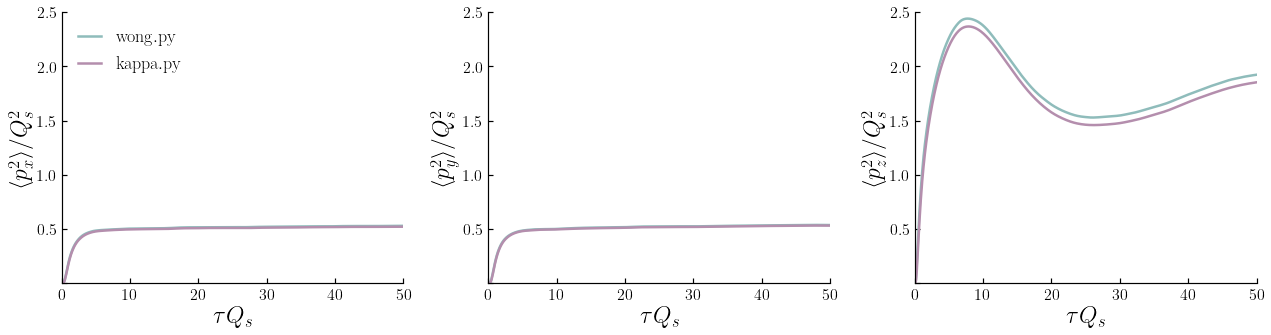

In [7]:
import matplotlib.pyplot as plt
import numpy as np 

plt.style.use('nord_theme_light.mpltstyle')
plt.rcParams["figure.figsize"] = (18,5)
plt.rcParams["figure.subplot.wspace"] = 0.2

fig, ax = plt.subplots(1, 3)

# dimensionless quantities
labels = [r'$\langle p_x^2\rangle/Q_s^2$', r'$\langle p_y^2\rangle/Q_s^2$', r'$\langle p_z^2\rangle/Q_s^2$']
for i in range(3):
    ax[i].plot(tau_wong*Qs/hbarc, mom_broad_wong[:, i]/Qs**2,  label=r'$\mathrm{wong.py}$', linewidth=2.5)
    ax[i].plot(tau_kappa*Qs/hbarc, mom_broad_kappa[:, i]/Qs**2, label=r'$\mathrm{kappa.py}$', linewidth=2.5)
    ax[i].set_xlabel(r'$\tau Q_s$')
    ax[i].set_ylabel(labels[i])
    ax[i].set_xlim(0, 50)
    ax[i].set_ylim(0, 2.5)
    ax[i].yaxis.get_major_ticks()[0].label1.set_visible(False)

ax[0].legend(loc='upper left')

plt.tight_layout()
plt.savefig('wong_vs_kappa.png', dpi=300, transparent=False, facecolor='white')